Preliminary stuff - coding up a 2d vertex model as in (Bi et al _Nat Phys_ 2015)

In [ ]:
# Implementation details:
# vertices are kept in two arrays:
    # Location list: nx2 array with coordinates
    # Adjacency/edgelengths: adjacency list with (index,edge length) tuples
# algorithm: each iteration,
    # gradient descent on a vertex position
    # re-evaluate each edge from that vertex. 
        # If its length is less than l*, check if a T1 transition would decrease the energy.
            # Do it if so.
    # repeat until convergence.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from vertex_model_2d import VertexModel

In [2]:
def same(x,y):
    return (x and y) or ((not x) and (not y))
def switchaforb(lis,a,b):
    lis[lis.index(a)] = b

In [605]:
class VertexModel:
    #TODO compute energies
    boxsize = 1.
    A0 = 1./12
    p0 = 1
    r = 1
    def __init__(self, locs, adjs):
        self.v = locs
        self.adj = adjs
        self.edgelens = [map(np.linalg.norm,self.get_edges(i)) for i in range(len(locs))]
        
        self.faces = self.find_all_faces()
        self.faceadj = self.make_faceadj()
        self.faceareas = map(self.get_facearea, range(len(self.faces)))
        self.perims = map(self.get_perim, range(len(self.faces)))
        
        self.energy = self.total_mechanical_energy()
    #Getters and setters
    def get_vert(self,idx):
        return self.v[idx].copy()
    def get_adj(self,idx):
        return self.adj[idx][:]
    def neighbors(self,idx):
        # returns neighbors of the vertex idx: list of positions.
        adjacency = self.adj[idx]
        return map(lambda x: self.v[x][:],adjacency)
    def get_edge(self,idx1,idx2):
        # returns the vector which points in the direction of idx1 to idx2 and has length equal to the edge length.
        # Use to correct for periodic boundary conditions.
        loc1 = self.get_vert(idx1)
        loc2 = self.get_vert(idx2)
        naive_edge = loc2-loc1
        #print naive_edge
        if np.linalg.norm(naive_edge)>VertexModel.boxsize/2.:
            if np.abs(naive_edge[0])>np.abs(naive_edge[1]):
                if naive_edge[0]>0:
                    loc2[0]-=VertexModel.boxsize
                else:
                    loc2[0]+=VertexModel.boxsize
            else:
                if naive_edge[1]>0:
                    loc2[1]-=VertexModel.boxsize
                else:
                    loc2[1]+=VertexModel.boxsize
        return loc2-loc1
    def get_edges(self,idx):
        # return all the edges from a single vertex
        loc = self.get_vert(idx)
        neighbors = self.get_adj(idx)
        return map(lambda x: self.get_edge(idx,x), neighbors)
    def get_face(self,v1,v2,v3):
        #return the actual face containing those three vertices in order
        facetest = self.find_face(v1,v2,v3)
        for f in range(len(self.faces)):
            if set(facetest)==set(self.faces[f]):
                return f, self.faces[f]
    
    #Dealing with faces
    def find_face(self,v1,v2,v3):
        ## find the face that includes the three indices idx1-idx2-idx3
        edges2 = self.get_edges(v2)
        
        idx1_2 = self.get_adj(v2).index(v1)
        idx3_2 = self.get_adj(v2).index(v3)
        idxn_2 = [i for i in range(3) if (i!=idx1_2 and i!=idx3_2)][0]
        
        #cw or ccw
        ccw = False
        angles2 = [np.arctan2(x[1],x[0]) for x in edges2]
        #print angles2
        if same((angles2[idx3_2]>angles2[idxn_2]),(angles2[idxn_2]>angles2[idx1_2])):
            #print 'between'
            if angles2[idx3_2]>angles2[idx1_2]:
                ccw = False
            else:
                ccw = True
        else:
            if angles2[idx3_2]>angles2[idx1_2]:
                ccw = True
            else:
                ccw = False
        
        #print ccw
        #travel around the face and get the vertices
        face = [v1, v2, v3]
        prev_vertex = v2
        current_vertex = v3

        while current_vertex!=v1:
            #get the other two neighbors
            adj = self.get_adj(current_vertex)
            edg = self.get_edges(current_vertex)
            angs = [np.arctan2(x[1],x[0]) for x in edg]
            
            idx_next = range(3)
            idx_prev = adj.index(prev_vertex)
            #print adj
            idx_next.remove(idx_prev)
            
            if same((angs[idx_next[0]]>angs[idx_prev]),(angs[idx_prev]>angs[idx_next[1]])):
                if angs[idx_next[0]]>angs[idx_next[1]]:
                    if ccw:
                        face+=[adj[idx_next[0]]]
                    else:
                        face+=[adj[idx_next[1]]]
                else:
                    if not ccw:
                        face+=[adj[idx_next[0]]]
                    else:
                        face+=[adj[idx_next[1]]]
            else:
                if angs[idx_next[0]]>angs[idx_next[1]]:
                    if not ccw:
                        face+=[adj[idx_next[0]]]
                    else:
                        face+=[adj[idx_next[1]]]
                else:
                    if ccw:
                        face+=[adj[idx_next[0]]]
                    else:
                        face+=[adj[idx_next[1]]]
            
            prev_vertex = current_vertex
            current_vertex = face[-1]
            #print current_vertex
        
        return face[:-1]
    def find_all_faces(self):
        #goes along each edge to search for all the faces. 
        #Returns a list of faces, each represented by a list of vertices
        faces = []
        facesets = []
        for v in range(len(self.v)):
            n = self.adj[v]
            for w in n:
                n2 = [i for i in self.adj[w] if i!=v]
                #print v,w,n2[0]
                #print v,w,n2[1]
                face0 = self.find_face(v,w,n2[0])
                face1 = self.find_face(v,w,n2[1])
                if set(face0) not in facesets:
                    faces+= [face0]
                    facesets+=[set(face0)]
                if set(face1) not in facesets:
                    faces+= [face1]
                    facesets+=[set(face1)]
                
        return faces
    def make_faceadj(self):
        #makes a list of face indices by vertex: each vertex is part of three faces.
        faceadj = [[] for i in range(len(self.v))]
        for faceidx in range(len(self.faces)):
            for v in self.faces[faceidx]:
                faceadj[v]+=[faceidx]
        return faceadj
    def get_facearea(self,idx):
        face = self.faces[idx]
        vertices = [np.array([0.,0.])]
        this_v = np.array([0.,0.])
        for i in range(len(face)-1):
            edge = self.get_edge(face[i],face[i+1])
            #print edge
            this_v = this_v + edge
            vertices.append(this_v[:])
        #print vertices
        return VertexModel.PolygonArea(vertices)
    def get_faceverts(self,face):
        vertices = [np.array([0.,0.])]
        this_v = np.array([0.,0.])
        facee = face+[face[0]]
        for i in range(len(face)):
            edge = self.get_edge(facee[i],facee[i+1])
            #print edge
            this_v = this_v + edge
            vertices.append(this_v[:])
        verts = np.array(vertices)
        #plt.figure()
        #plt.quiver(verts[:-1,0], verts[:-1,1], verts[1:,0]-verts[:-1,0], verts[1:,1]-verts[:-1,1], scale_units='xy', angles='xy', scale=1)

        return vertices
    def get_perim(self,idx):
        #perimeter of face idx
        face = self.faces[idx]
        perim = 0
        for i in range(len(face)):
            edge = self.get_edge(face[i-1],face[i])
            #print edge
            perim+=np.linalg.norm(edge)
        #print vertices
        return perim
    def rotate_face(self,face_idx,v_idx):
        #return a rotation of the face such that v_idx is not at the end
        face_init = self.faces[face_idx][:]
        if face_init[0]==v_idx:
            return [face_init[-1]]+face_init[0:-1]
        elif face_init[-1]==v_idx:
            return face_init[1:]+[face_init[0]]
        else:
            return face_init
    #Computing energies
    def total_mechanical_energy(self):
        A0 = VertexModel.A0
        p0 = VertexModel.p0
        r = VertexModel.r
        
        a_tilde = np.array(self.faceareas)/A0
        p_tilde = np.array(self.perims)/np.sqrt(A0)
        
        return np.sum(np.power(a_tilde-1,2) + np.power(p_tilde-p0,2)/r)
    
    #Gradient descent
    def gradient_descent_one_vertex(self,idx, gamma):
        # move a vertex against the energy gradient
        adj = self.adj[idx]
        
        
        faceadj = self.faceadj[idx]
        #faces is a list of vertex indices
        faces =  map(lambda x: self.rotate_face(x,idx), faceadj)
        
        #full_faces is the list of positions
        full_faces =  map(lambda x: self.get_faceverts(x), faces)
        
        v = map(lambda x: full_faces[x][faces[x].index(idx)], range(len(faces)))
        #print 'v:',v
        #print faces
        #print full_faces
        #faces is now the two positions that are adjacent to vertex idx, in the order they appear in full_faces
        faces = map(lambda x: [full_faces[x][i] for i in range(len(faces[x])) if faces[x][i] in adj], range(len(faces)))
        #print 'faces',faces
        
        a_tildes = np.array(map(lambda x: self.faceareas[x]/VertexModel.A0, faceadj))
        p_tildes = np.array(map(lambda x: self.perims[x]/np.sqrt(VertexModel.A0), faceadj))
        
        dadx_comps = np.array(map(lambda x: 0.5/VertexModel.A0*VertexModel.ShoelaceSign(full_faces[x])*(faces[x][1][1]-faces[x][0][1]), range(len(faces))))
        #print 'dadx:',dadx_comps
        dpdx_comps = np.array(map(lambda x: 1/np.sqrt(VertexModel.A0)*((v[x][0]-faces[x][0][0])/np.linalg.norm(v[x]-faces[x][0])+(v[x][0]-faces[x][1][0])/np.linalg.norm(v[x]-faces[x][1])), range(len(faces))))
        #print 'dpdx:',dpdx_comps
        dady_comps = np.array(map(lambda x: 0.5/VertexModel.A0*VertexModel.ShoelaceSign(full_faces[x])*(faces[x][0][0]-faces[x][1][0]), range(len(faces))))
        #print 'dady:',dady_comps
        dpdy_comps = np.array(map(lambda x: 1/np.sqrt(VertexModel.A0)*((v[x][1]-faces[x][0][1])/np.linalg.norm(v[x]-faces[x][0])+(v[x][1]-faces[x][1][1])/np.linalg.norm(v[x]-faces[x][1])), range(len(faces))))
        #print v[0][1]-faces[0][0][1]
        #print v[0][1]-faces[0][1][1]
        #print 'dpdy:',dpdy_comps
        gradient = np.array([2*np.dot((a_tildes-1),dadx_comps)+2/VertexModel.r*np.dot((p_tildes-VertexModel.p0),dpdx_comps), 
                             2*np.dot((a_tildes-1),dady_comps)+2/VertexModel.r*np.dot((p_tildes-VertexModel.p0),dpdy_comps)])
        #print gradient
        
        #update position, edge lengths, face areas
        newpos = self.v[idx]-gamma*gradient
        for i in range(2):
            if newpos[i]>VertexModel.boxsize:
                newpos[i] -= VertexModel.boxsize
            elif newpos[i]<0:
                newpos[i] += VertexModel.boxsize
        self.v[idx] = newpos
        self.edgelens[idx] = map(np.linalg.norm, self.get_edges(idx))
        for i in self.faceadj[idx]:
            self.faceareas[i] = self.get_facearea(i)
            self.perims[i] = self.get_perim(i)
            
        E = self.energy
        self.energy = self.total_mechanical_energy()
        #print E-self.energy
        return self.energy-E

    def gradient_descent_step(self, gamma):
        for i in range(len(self.v)):
            step = self.gradient_descent_one_vertex(i, gamma)
        return step

    def gradient_descent_no_t1(self, gamma, tol):
        step = 2*tol
        while abs(step)>tol:
            step = self.gradient_descent_step(gamma)
            if step>0:
                print 'ascending'

    #Topological transition
    def t1_trans(self, idx1, idx2):
        # T1 transition involving vertices idx1 and idx2.
        loc1 = self.get_vert(idx1)
        loc2 = self.get_vert(idx2)
        neighbors1 = self.adj[idx1]
        n1c = neighbors1[:]
        neighbors2 = self.adj[idx2]
        n2c = neighbors2[:]
        edges1 = self.get_edges(idx1)
        edges2 = self.get_edges(idx2)
        
        for i in range(len(n1c)):
            if n1c[i] == idx2:
                n1c.pop(i)
                edge = edges1.pop(i)
                break
        for i in range(len(n2c)):
            if n2c[i] == idx1:
                n2c.pop(i)
                edges2.pop(i)
                break
        
        print n1c, edges1, n2c, edges2
        
        dirs1 = map(lambda x: (x-np.dot(edge,x)), edges1)
        dirs2 = map(lambda x: (x-np.dot(edge,x)), edges2)
        
        v11 = n1c[1]
        v10 = n1c[0]
        v20 = n2c[0] 
        v21 = n2c[1]
        
        #find the faces involved:
        #print self.find_face(v10,idx1,v11)
        A, faceA = self.get_face(v10,idx1,v11)
        B, faceB = self.get_face(v10,idx1,idx2)
        C, faceC = self.get_face(v11,idx1,idx2)
        D, faceD = self.get_face(v20,idx2,v21)
        
        self.adj[idx1] = n1c
        neighbors1 = n1c
        self.adj[idx2] = n2c
        neighbors2 = n2c
        
        #figure out which way to switch the edges
        if np.dot(dirs1[0],dirs2[0])>0:
            #update the adjacencies and edge lengths
            neighbors1[1] = v20
            neighbors1+= [idx2]
            self.edgelens[idx1] = map(np.linalg.norm,self.get_edges(idx1))
            
            a = self.adj[v20]
            i = a.index(idx2)
            a[i] = idx1
            self.edgelens[v20][i] = self.edgelens[idx1][1]
            
            neighbors2[0] = v11
            neighbors2+=[idx1]
            self.edgelens[idx2] = map(np.linalg.norm,self.get_edges(idx2))
            
            a = self.adj[v11]
            i = a.index(idx1)
            a[i] = idx2
            self.edgelens[v11][i] = self.edgelens[idx2][0]
            
            #update faces and face adjacency
            self.faces[A] = self.find_face(v10,idx1,idx2)
            self.faces[B] = self.find_face(v10,idx1,v20)
            self.faces[C] = self.find_face(v11,idx2,v21)
            self.faces[D] = self.find_face(v21,idx2,idx1)
            
            switchaforb(self.faceadj[idx1], C, D)
            switchaforb(self.faceadj[idx2], B, A)
        else:
            neighbors1[1] = v21
            neighbors1+= [idx2]
            self.edgelens[idx1] = map(np.linalg.norm,self.get_edges(idx1))
            
            a = self.adj[v21]
            i = a.index(idx2)
            a[i] = idx1
            self.edgelens[v21][i] = self.edgelens[idx1][1]
            
            neighbors2[1] = v11
            neighbors2+=[idx1]
            self.edgelens[idx2] = map(np.linalg.norm,self.get_edges(idx2))
            
            a = self.adj[v11]
            i = a.index(idx1)
            a[i] = idx2
            self.edgelens[v11][i] = self.edgelens[idx2][1]
            
            #update faces and face adjacency
            self.faces[A] = self.find_face(v10,idx1,idx2)
            self.faces[B] = self.find_face(v10,idx1,v21)
            self.faces[C] = self.find_face(v11,idx2,v20)
            self.faces[D] = self.find_face(v21,idx1,idx2)
            
            switchaforb(self.faceadj[idx1], C, D)
            switchaforb(self.faceadj[idx2], B, A)
        self.faceareas[A] = self.get_facearea(A)
        self.faceareas[B] = self.get_facearea(B)
        self.faceareas[C] = self.get_facearea(C)
        self.faceareas[D] = self.get_facearea(D)
    #useful helper functions
    def show_model(self):
        #draw the vertex model
        varray = np.array(self.v)
        for i in range(len(self.v)):
            vv = self.v[i]
            es = self.get_edges(i)
            [plt.plot([vv[0],vv[0]+e[0]],[vv[1],vv[1]+e[1]],color='k') for e in es]
        plt.scatter(varray[:,0],varray[:,1])
        plt.xlim([0,VertexModel.boxsize])
        plt.ylim([0,VertexModel.boxsize])
        plt.axes().set_aspect('equal')
     
    @staticmethod
    def PolygonArea(list_of_points):
        corners = np.array(list_of_points)
        n = len(corners) # of corners
        area = 0.0
        for i in range(n):
            j = (i + 1) % n
            area += corners[i][0] * corners[j][1]
            area -= corners[j][0] * corners[i][1]
        area = abs(area) / 2.0
        return area

    @staticmethod
    def ShoelaceSign(list_of_points):
        corners = np.array(list_of_points)
        n = len(corners) # of corners
        area = 0.0
        for i in range(n):
            j = (i + 1) % n
            area += corners[i][0] * corners[j][1]
            area -= corners[j][0] * corners[i][1]
        #print area
        return -((area>0)-0.5)*2

In [606]:
#test periodic hexagonal array
x = [0.2,0.4,0.6,0.8]
y = [6./7,5./7,4./7,3./7,2./7,1./7]
locs = map(np.array, zip(list(np.meshgrid(x,y)[0].flatten()),list(np.meshgrid(x,y)[1].flatten())))

adjs = [[1,4,20],[0,5,21],[3,6,22],[2,7,23],
       [0,7,8],[1,6,9],[2,5,10],[3,4,11],
        [4,9,12],[5,8,13],[6,11,14],[7,10,15],
        [8,15,16],[9,14,17],[10,13,18],[11,12,19],
        [12,17,20],[13,16,21],[14,19,22],[15,18,23],
        [16,23,0],[17,22,1],[18,21,2],[19,20,3]
       ]


In [607]:
vm = VertexModel(locs,adjs)

[[1, 4, 20], [0, 5, 21], [3, 6, 22], [2, 7, 23], [0, 7, 8], [1, 6, 9], [2, 5, 10], [3, 4, 11], [4, 9, 12], [5, 8, 13], [6, 11, 14], [7, 10, 15], [8, 15, 16], [9, 14, 17], [10, 13, 18], [11, 12, 19], [12, 17, 20], [13, 16, 21], [14, 19, 22], [15, 18, 23], [16, 23, 0], [17, 22, 1], [18, 21, 2], [19, 20, 3]]


119.9259711026735

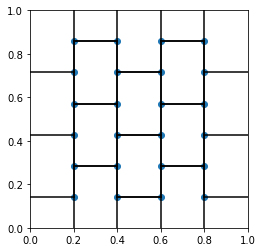

In [608]:
vm.show_model()
print vm.adj
vm.total_mechanical_energy()

total area: 1.0


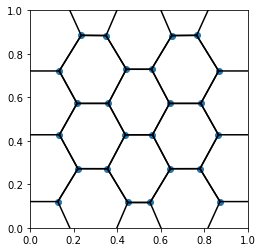

In [609]:
vm.gradient_descent_no_t1(0.00001,0.001)
print 'total area:',sum(vm.faceareas)
vm.show_model()